# DSCI 100 Group Project Report

## Predicting Prize Money for Male Tennis Players


## Loading Libraries

In [182]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

### Introduction

Tennis is a widely appreciated and watched game worldwide. There are more than 1 billion tennis fans [1] who follow the sport and desire to access player statistics over time, like how many matches a player won, what is the winning ratio of a player against his rivals, what is the winning pattern of a player on various kinds of surface, and many more questions. Tennis stats are very limited and one of the best platforms for tennis statistics is “Ultimate Tennis Statistics”. [2]

In this work, we will attempt to determine the best variables that can be used to predict the prize money that a player will win at a stage of their career.

For this work, the data was downloaded from Ultimate Tennis Statistics. [3] This data contains various information summarized for the top 500 male tennis players. The data contains 37 variables about the players. These variables are of either continuous and categorical types. The continuous variables include age, prize money, current rank, best rank, height, weight, and more, while the categorical variables include backhand (two handed or one handed), plays (left hand or right hand) and favorite surface (clay, grass, hard slow, soft and all-rounder), and more.

Importantly, the data is not clean; thus, it needs proper cleaning before starting other analyses. For example, there are some cells with no values, so we will delete those observations as a part of data cleaning. The column names of the data are spaced, so we will fix them accordingly. Finally, we will use the best variables we find of the cleaned data as the explanatory variable to predict prize money (response variable) using the appropriate regression model.

### Loading Data From Web

In [183]:
# Dataset read into R.

url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"

player_stats <- read_csv(url)
head(player_stats)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Preliminary Exploratory Data Analysis

In [184]:
na_count <- colSums(is.na(player_stats))
na_count


na_count_frame <- data.frame(variable = names(na_count), na_count = unname(na_count))
head(na_count_frame)
tail(na_count_frame)

...1              Age          Country            Plays 
               0                1                1               47 
       Wikipedia     Current Rank        Best Rank             Name 
               1                5                1                0 
        Backhand      Prize Money           Height Favorite Surface 
              92               81              385              259 
      Turned Pro          Seasons           Active Current Elo Rank 
             254              126              218              316 
   Best Elo Rank  Peak Elo Rating  Last Appearance           Titles 
             263              263              158              405 
       GOAT Rank      Best Season          Retired          Masters 
             399              399              420              484 
      Birthplace        Residence           Weight            Coach 
             480              480              480              481 
        Facebook          Twitter        Nicknames      Grand Slams 
             483              481              488              493 
      Davis Cups         Web Site        Team Cups         Olympics 
             468              461              494              498 
  Weeks at No. 1      Tour Finals 
             496              494

,variable,na_count
,<chr>,<dbl>
1,...1,0
2,Age,1
3,Country,1
4,Plays,47
5,Wikipedia,1
6,Current Rank,5


,variable,na_count
,<chr>,<dbl>
33,Davis Cups,468
34,Web Site,461
35,Team Cups,494
36,Olympics,498
37,Weeks at No. 1,496
38,Tour Finals,494


### Selecting Predictor Variables To Test

There are a total of 38 variables in the data, but many of them have numerous missing values (NA), as you can see from our list/dataframe above. Thus, to maintain a decent size of the data for our analysis, we removed those variables with too many missing values, like Grand Slams, favorite surface, Tour Finals and Olympics etc. Additionally, there were some variables that, we found, were not suitable for the analysis, such as twitter, nickname and birthplace, etc. We were left with age, country, plays, current_rank, best_rank, and backhand. Among these variables, country, plays and backhand were categorical variables, so we avoided using them in our predictive analysis. Finally, we will be checking to see if age, current rank and best rank will be good predictors for our model.

### Cleaning and Wrangling Data

In [185]:
#Fixed titles and changed the types
player_stats <- player_stats |>
    rename_all(~ gsub(" ", "_", .)) 

# Selecting the needed the columns (Age, Best_Rank, Prize_Money), 
# Filtering out rows which don't have any prize money won,
# Changing the column types to correct type
# Getting rid of the date of births and the best_rank dates from both columns. 
# Getting rid of everything besides the number in the Prize_Money column  

player_stats_tidy <- player_stats |> 
    select(Age, Current_Rank, Best_Rank, Prize_Money) |>
    filter(!is.na(Prize_Money)) |>
    filter(!is.na(Age)) |>
    filter(!is.na(Current_Rank)) |>
    filter(!is.na(Best_Rank)) |>
    mutate(Age = as.integer(sub("\\s*\\(.*\\)", "", Age))) |>
    mutate(Best_Rank = as.integer(sub("\\s*\\(.*\\)", "", Best_Rank))) |>
    mutate(Prize_Money = gsub("\\$", "", Prize_Money)) |>
    mutate(Prize_Money = gsub("US", "", Prize_Money)) |>
    mutate(Prize_Money = gsub("[^0-9]", "", Prize_Money)) |>
    mutate(Prize_Money = as.numeric(Prize_Money)) |>
    mutate(Current_Rank = gsub("\\(.*\\)", "", Current_Rank)) |>
    mutate(Current_Rank = as.integer(Current_Rank))

print("Player Stats Tidy Data Frame")
player_stats_tidy

[1] "Player Stats Tidy Data Frame"


Age,Current_Rank,Best_Rank,Prize_Money
<int>,<int>,<int>,<dbl>
18,326,316,59040
32,178,44,3261567
21,236,130,374093
⋮,⋮,⋮,⋮
20,382,380,57943
26,5,4,2213236815
22,451,408,61984


In [186]:
write_csv(player_stats_tidy, "player_stats_tidy.csv")

In [187]:
set.seed(2000) ### DO NOT CHANGE

# Data split into training and testing

player_stats_split <- initial_split(player_stats_tidy, prop = 0.75, strata = Prize_Money)
player_stats_training <- training(player_stats_split)
player_stats_testing <- testing(player_stats_split)

## Data Summarized in tables

[1] "Max Prize Money"


Prize_Money
<dbl>
2384663114


[1] "Min Prize Money"


Prize_Money
<dbl>
2893


[1] "Average Total Prize Money Won for every Age Group"


Age,Prize_Money
<int>,<dbl>
17,14340.0
18,182125.6
19,276646.3
⋮,⋮
36,1006655497
37,13376235
38,1002899210


[1] "Scatter Plot: Average Total Prize Money Won for every Age Group"


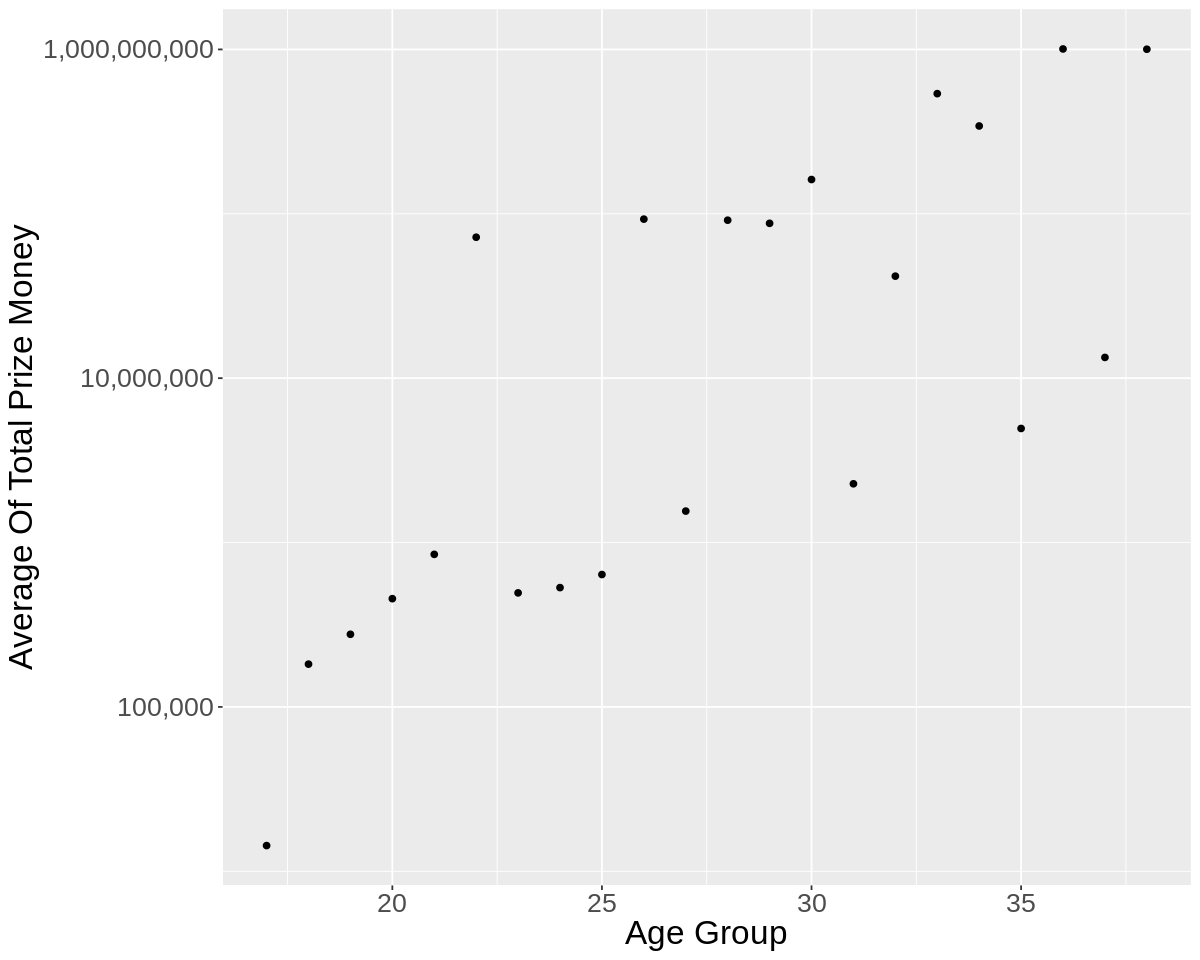

In [188]:
#Using only training data, summarize the data in at least one table.


max_prize_money <- player_stats_training |>
    select(Prize_Money) |>
    arrange(Prize_Money) |>
    slice(312)

print("Max Prize Money")
max_prize_money

min_prize_money <- player_stats_training |>
    select(Prize_Money) |>
    arrange(Prize_Money) |>
    slice(1)

print("Min Prize Money")
min_prize_money


# Average Total Prize Money Won for every Age group.
print("Average Total Prize Money Won for every Age Group")
average_age_prize_money <- player_stats_training |> 
    group_by(Age) |> 
    summarize(Prize_Money = mean(Prize_Money))

average_age_prize_money

options(repr.plot.height = 8, repr.plot.width = 10)
# Scatter plot showing the Average Total Prize Money won for every Age group. 
print("Scatter Plot: Average Total Prize Money Won for every Age Group")
average_age_prize_money_plot <- average_age_prize_money |>
    ggplot(aes(x = Age, y = Prize_Money)) + 
    geom_point() +
    xlab("Age Group") + 
    ylab("Average Of Total Prize Money") +
    scale_y_log10(labels = label_comma()) + 
    theme(text = element_text(size=20))

average_age_prize_money_plot


### Summary Of Data Tables


The most prize money won is 2384663114 USD and the least prize money won (excluding NA) is 2893 USD. All the y-axes of graphs in the preliminary data analysis are scaled using log10 to account for prize money increases drastically towards the larger values. 
The table “Average Total Prize Money Won for every Age Group” groups tennis players by age and then the mean prize money of each age group is computed. The bar chart shows a general trend of greater average prize money won as the age group increases. 




## Visualizations

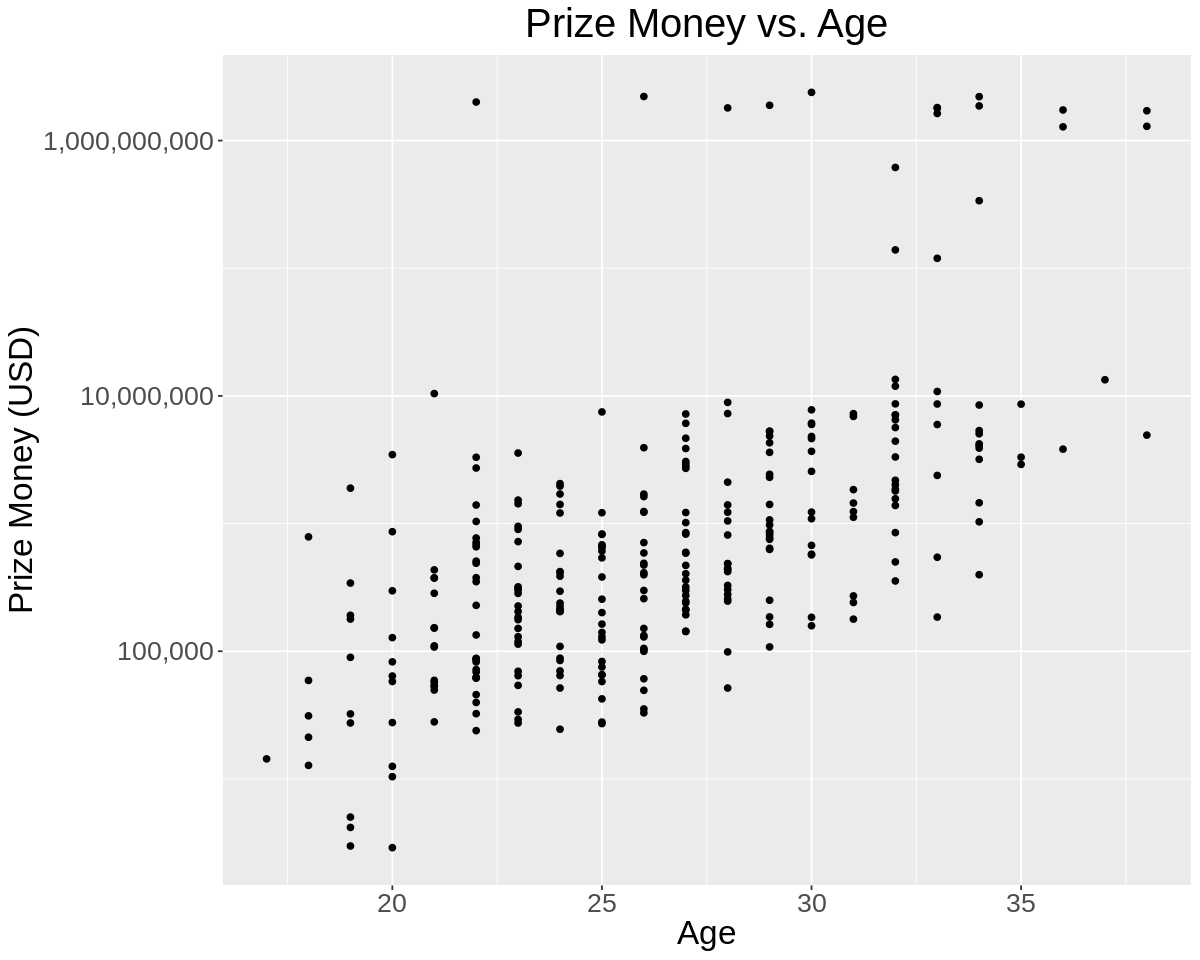

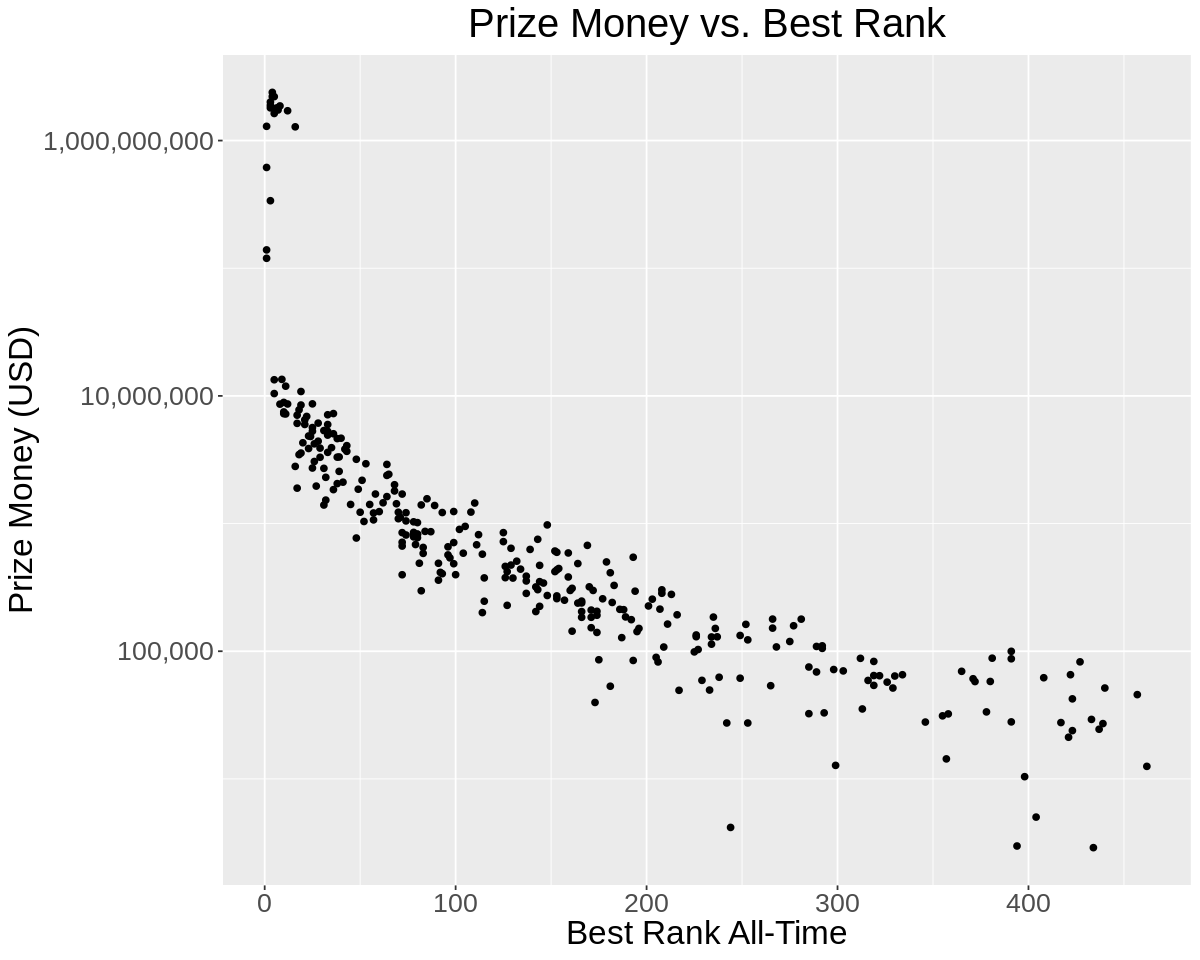

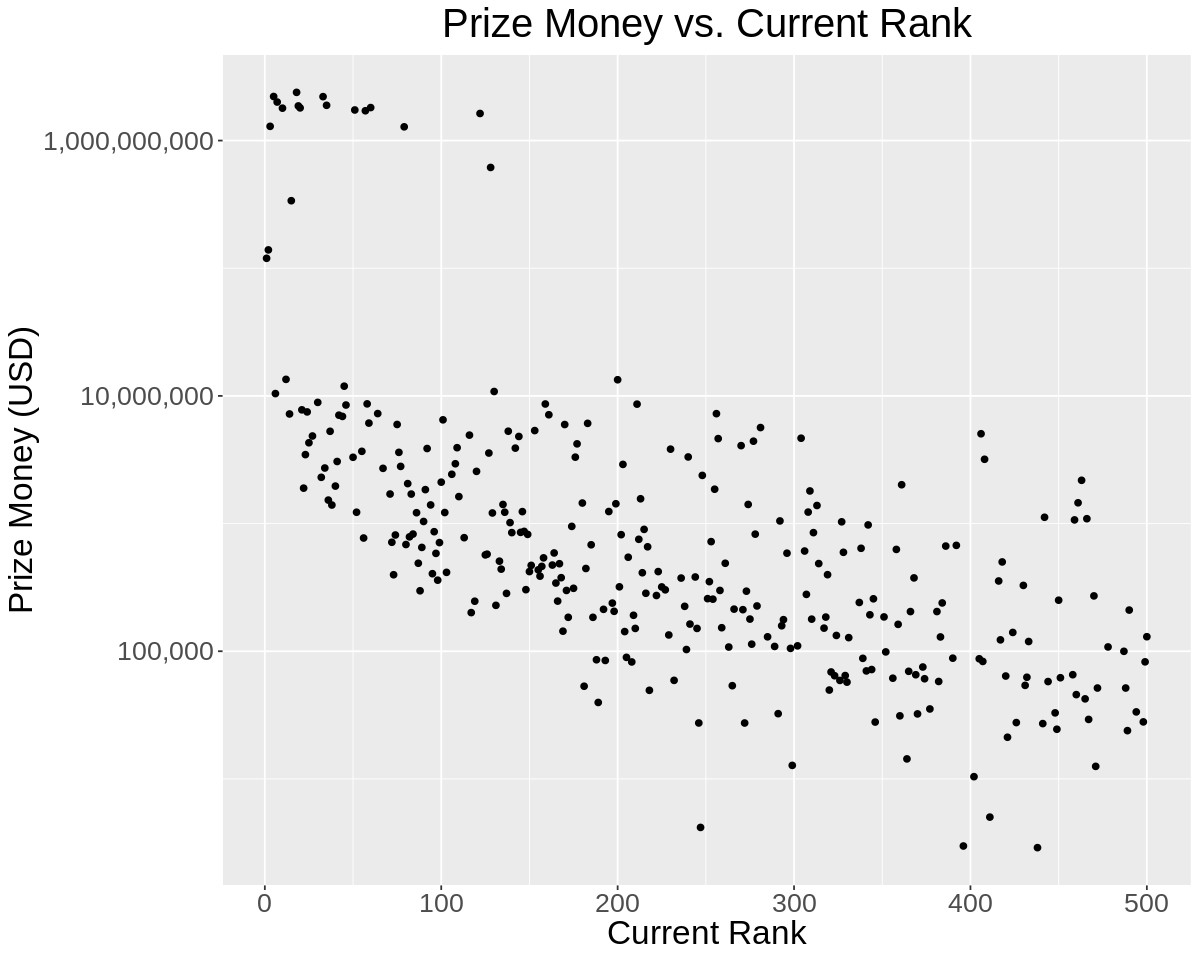

In [189]:
options(repr.plot.height = 8, repr.plot.width = 10)

player_stats_plot_age <- player_stats_training |> 
    ggplot(aes(x = Age, y = Prize_Money)) + 
    geom_point() +
    scale_y_log10(labels = label_comma()) +
    labs(x = "Age", y = "Prize Money (USD)", title = "Prize Money vs. Age") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

player_stats_plot_age


player_stats_plot_best_rank <- player_stats_training |> 
    ggplot(aes(x = Best_Rank, y = Prize_Money)) + 
    geom_point() +
    scale_y_log10(labels = label_comma()) +
    labs(x = "Best Rank All-Time", y = "Prize Money (USD)", title = "Prize Money vs. Best Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

player_stats_plot_best_rank

player_stats_plot_current_rank <- player_stats_training |> 
    ggplot(aes(x = Current_Rank, y = Prize_Money)) + 
    geom_point() +
    scale_y_log10(labels = label_comma()) +
    labs(x = "Current Rank", y = "Prize Money (USD)", title = "Prize Money vs. Current Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

player_stats_plot_current_rank

### Summary Of Visualizations 

<u>Prize Money Vs. Age </u>

There is a moderate positive relationship between age and prize money with a rapid increase in total prize money towards the larger ages. This makes sense because older age gives more time to accumulate total prize money. The relationship appears to be linear with a few outliers with much larger prize money. 

<u>Prize Money Vs. Best rank </u>
    
This graph shows a strong negative relationship between players’ best rank and total prize money won. There is a large drop in prize money between data points in the very low end of best rank and the rest of the ranks. The relationship appears to be curvilinear. The strong relationship suggests that best rank can be used as a good predictor for prize money.

<u>Prize Money Vs. Current rank </u>
    
Similar to the previous scatterplot, this graph shows a negative relationship between current rank and prize money won, with a large drop in prize money won between the low end of current rank and the rest of the data points. The relationship is still relatively robust, allowing us to use current rank as a predictor for prize money. 


### Choosing Our Predictors

Based off the above information we have come to the conclusion that we will be selecting age, current_rank, best_rank.

## Methods


In the kNN modeling, we will split this dataset into training (75%) and testing (25%) sets. Using cross validation (5-fold), we will select the optimal K value (from 1 - 50) with the lowest RMSPE (by plotting k value against RMSPE values) and use it to train our final model, which will be tested for accuracy on the test set data.

We believe age will be useful in our prediction because the older you are, the more time you have to win prize money. Additionally, best and current rank are good indicators of performance which translates to winning more tournaments with prize money rewards. 

Since all variables are on a continuous scale, we plan on using a knn regression model to predict total lifetime prize money using the players’ best rank, current rank, and age. Preliminary exploratory data analysis using plots have shown moderate to strong relationships. We will visualize the results by creating a scatter plot with our resulting data, and a prediction line. 


In [ ]:
set.seed(1235) # DO NOT CHANGE

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 

recipe <- recipe(Prize_Money ~., data = player_stats_training) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())

vfold <- vfold_cv(player_stats_training, v = 5, strata = Prize_Money)

workflow <- workflow() |>
       add_recipe(recipe) |>
       add_model(spec) 

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

results <- workflow |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    filter(mean == min(mean))
results

k_min <- results |>
          pull(neighbors)



best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

best_fit <- workflow() |>
          add_recipe(recipe) |>
          add_model(best_spec) |>
          fit(data = player_stats_training)

summary <- best_fit |>
           predict(player_stats_testing) |>
           bind_cols(player_stats_testing) |>
           metrics(truth = Prize_Money, estimate = .pred) |>
           filter(.metric == "rmse") 
summary

## Expected outcomes and significance 

We will expect to be able to predict the approximate prize money for a player in the top 500 by using best rank, current rank, and age as the classifiers. 

Our findings can help current pro tennis players with financial planning based on their predicted winnings in the future. In addition, these predictions can be helpful for up and coming tennis players predicted to go pro to attract sponsorships and endorsements based on their predicted winnings at their predicted rank at a specific age. 

As higher age allows a longer time period for players to pool up their prize money, future questions can look to find the prime ages where the average pro tennis player makes the most prize money. 


## References
1.How Many People Watch Tennis? [Tennis Viewership Statistics 2023]. Published May 26, 2023. Accessed June 22, 2023. https://playtoday.co/blog/stats/tennis-viewership-statistics/

2.Nair D. The Best Sources for Tennis Player Stats and Match Insights. Racquet Social. Published August 15, 2020. Accessed June 22, 2023. https://racquetsocial.com/six-sources-for-tennis-stats-and-insights/

3.Ultimate Tennis Statistics. Accessed June 22, 2023. https://www.ultimatetennisstatistics.com/